In [2]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly.io import to_image
init_notebook_mode(connected=True)

%matplotlib inline

In [3]:
#Read in the user_reviews data file
user_reviews_df = pd.read_csv("./Data/user_reviews.csv", index_col=[0])

FileNotFoundError: [Errno 2] No such file or directory: './Data/user_reviews.csv'

In [4]:
# Looking at the data from the 
user_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 598158 entries, 8 to 1132357
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    598158 non-null  int64 
 1   recipe_id  598158 non-null  int64 
 2   date       598158 non-null  object
 3   rating     598158 non-null  int64 
 4   review     598154 non-null  object
dtypes: int64(3), object(2)
memory usage: 27.4+ MB


We have 598,158 user ratings. There are four missing review column. Because this is such a small amount, we can drop these columns in case we want to later use review comments in some form. 

In [5]:
#Drop 4 missing reviews
user_reviews_df.dropna(inplace=True)

In [6]:
#Check no missing values
user_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 598154 entries, 8 to 1132357
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    598154 non-null  int64 
 1   recipe_id  598154 non-null  int64 
 2   date       598154 non-null  object
 3   rating     598154 non-null  int64 
 4   review     598154 non-null  object
dtypes: int64(3), object(2)
memory usage: 27.4+ MB


In [7]:
#Turn user_id, recipe_id, review to string
user_reviews_df["review"] = user_reviews_df["review"].astype(str)
user_reviews_df["user_id"] = user_reviews_df["user_id"].astype(str)
user_reviews_df["recipe_id"] = user_reviews_df["recipe_id"].astype(str)

In [8]:
#Turn rating into a float
user_reviews_df["rating"] = user_reviews_df["rating"].astype(float)

In [9]:
#Check that the changes worked
user_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 598154 entries, 8 to 1132357
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    598154 non-null  object 
 1   recipe_id  598154 non-null  object 
 2   date       598154 non-null  object 
 3   rating     598154 non-null  float64
 4   review     598154 non-null  object 
dtypes: float64(1), object(4)
memory usage: 27.4+ MB


## Visualizing Rating Data

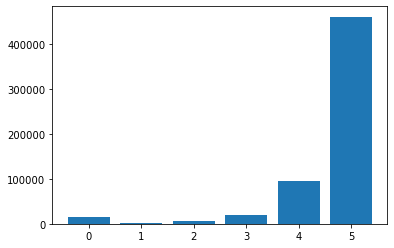

In [10]:
#Creating a bar chart to see the distribution of ratings
rating_count = user_reviews_df["rating"].value_counts().sort_index(ascending=False)

plt.bar(rating_count.index, rating_count.values);

In [11]:
rating_count

5.0    460937
4.0     95038
3.0     19168
2.0      5548
1.0      2770
0.0     14693
Name: rating, dtype: int64

77% of our new dataset includes 5 star reviews, which heavily skews the data and will affect the recommendation portal. 

We also notice that 2.4% of our dataset includes a 0 rating. It would be important to see if these are actually 0s or if they are imputed value for missing ratings. 

## Dealing with 0 Ratings

In [12]:
#Looking at the 0 ratings to see if they are actually 0s or missing ratings
user_reviews_df.loc[user_reviews_df["rating"] == 0]

,user_id,recipe_id,date,rating,review
12,468945,134728,2008-02-20,0.0,Made my own buttermilk w/ vinegar and milk. U...
23,681408,225241,2008-03-14,0.0,This is a very good recipe. We also want to c...
56,980899,79222,2010-10-18,0.0,"I used half cream and half 1% milk, added anot..."
539,93911,306919,2010-07-08,0.0,I haven't tried this recipe so I'm not rating ...
642,921361,232042,2014-10-03,0.0,Tasted great and was super easy to make. Thank...
...,...,...,...,...,...
1131752,194886,99731,2013-01-24,0.0,"This is a great recipe, I thought I had review..."
1131780,113509,130019,2012-04-20,0.0,Hubby and I thought this was good. Neither of ...
1131953,374506,39724,2008-03-19,0.0,Great!!! After the turkey was done I browned t...
1132016,329378,39902,2006-10-19,0.0,"While the recipe calls for 3 cups of cheese, t..."


It looks like the 0s are both a mix of positive and negative (or neutral reviews). While it is a small subset of our dataset it could be important to include these reviews considering the skew of our data. We could impute ratings based on the language used in the "review" column using KNN Imputer, but this could lead to data leakage concerns and long processing times. In this case we will just drop these data points.

In [13]:
#Dropping rating that are 0 
#df.drop(df.loc[df['line_race']==0].index, inplace=True)
user_reviews_df.drop(user_reviews_df.loc[user_reviews_df["rating"]==0].index, inplace=True)

In [14]:
#Check thaat the 0s are gone
user_reviews_df["rating"].value_counts()

5.0    460937
4.0     95038
3.0     19168
2.0      5548
1.0      2770
Name: rating, dtype: int64

In [15]:
#Need to recheck that our recipes all have five ratings
user_reviews_df["recipe_id"].value_counts()

27208     1009
89204      979
32204      826
39087      825
69173      740
          ... 
10866        1
9340         1
131032       1
27976        1
262485       1
Name: recipe_id, Length: 53127, dtype: int64

In [16]:
# Number of recipes in our data frame
len(user_reviews_df["recipe_id"].value_counts())

53127

In [17]:
# Creating a list of recipe_review_counts for each recipe
# Remove recipes with less than 5 review counts

recipe_review_counts = user_reviews_df["recipe_id"].value_counts()

user_reviews_df = user_reviews_df[user_reviews_df["recipe_id"].isin(recipe_review_counts[recipe_review_counts >= 5].index)]

# Check that recipes with under 5 reviews were removed

len(user_reviews_df["recipe_id"].value_counts())


40527

In [18]:
# See what percentage of our recipes were dropped 
40527/53127

0.7628324580721667

In [20]:
# Checking the amount of reviews per user. 
# For recommendation modeling we need at least 5 reviews per reader. 

user_reviews_df["user_id"].value_counts()

37449         2789
383346        2396
424680        2145
128473        2024
89831         1893
              ... 
263381           1
142053           1
603432           1
2001550810       1
467510           1
Name: user_id, Length: 18943, dtype: int64

In [19]:
# Create a list review counts for each user 
# Keep only those with more than 5 in the dataframe 
review_counts = user_reviews_df["user_id"].value_counts()
user_reviews_df = user_reviews_df[user_reviews_df["user_id"].isin(review_counts[review_counts >= 5].index)]

# Check that users with under 5 reviews were removed
len(user_reviews_df["user_id"].value_counts())

17096

In [20]:
#See what percentage of our users are left in our data set
17096/18943

0.9024969645779444

We lost a fair bit more of our data - about 25% of our recipes - and 10% of our users, but now we make sure we have users with at least five reviews. And the user data is now ready for Surprise. 

In [21]:
#Save off as a csv file
#user_reviews_df.to_csv("./Data/user_reviews_no_zero.csv")

## Final User Data Set Exploration

In [22]:
user_reviews_df["user_id"].value_counts()

37449     2789
383346    2396
424680    2145
128473    2024
89831     1893
          ... 
903317       5
739440       5
47847        5
327711       5
209382       5
Name: user_id, Length: 17096, dtype: int64

In [23]:
user_reviews_df["recipe_id"].value_counts()

27208     990
89204     959
32204     806
39087     806
69173     728
         ... 
392260      3
55716       3
86185       3
342659      3
102596      3
Name: recipe_id, Length: 40526, dtype: int64

Our final user data set with recipe reviews has 537,267 reviews on 40,526 recipes from 17,096 reviewers/users.  

In [8]:
user_reviews_df["rating"].value_counts()

5.0    426151
4.0     86486
3.0     17360
2.0      4952
1.0      2318
Name: rating, dtype: int64

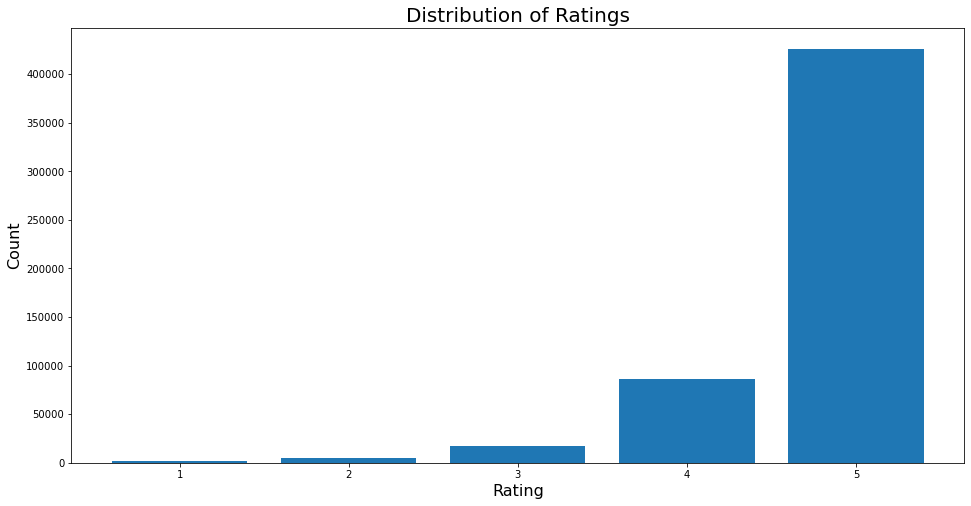

In [10]:
data = 426151, 86486, 17360, 4952, 2318
ratings = 5, 4, 3, 2, 1

fig, ax = plt.subplots(figsize=(16, 8))
plt.bar(ratings, data,  align='center', label=data, color="#1f77b4")
plt.ylabel("Count", fontsize=16)
plt.xlabel("Rating", fontsize=16),
plt.title("Distribution of Ratings", fontsize=20);
#plt.savefig("./Images/rating_dist")